# New York City Yellow Taxi Data Analysis 

Let's look at the 2016 Yellow Taxi trip data

![Yellow Cab](./img/ny_yellow_cab.jpg)


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# start by importing the RAPIDS Memory Manager
import rmm

rmm.reinitialize(   
    managed_memory=True,        # Use manged memory, this allows for oversubscription of the GPU
    pool_allocator=False,       # default is False
    devices=0,                  # GPU device IDs to register. By default registers only GPU 0.
)

In [3]:
# also, let's see how much memory is available in the system
import subprocess

def get_gpu_memory_size():
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.total'
            , '--format=csv,nounits,noheader'
        ]
    )

    
    return result.decode('utf-8').strip().split('\n')#).strip().split('\n')

available_gpu_mem = int(get_gpu_memory_size()[1])

In [4]:
import cudf
print(cudf._cuda.gpu.deviceGetName(0) + " has " + str(available_gpu_mem) + "GB of memeory")

Quadro GV100 has 32508GB of memeory


In [5]:
# load the other used libraries
import numpy as np
import pandas as pd
import math

import cugraph

import os
import gc

from collections import OrderedDict
import argparse
import datetime
import time

## Download the data

In [6]:
top_dir = "./"
data_dir = "./nyctaxi"

In [7]:
# Download Taxi data

if os.path.exists(data_dir) == False:
    import nyctaxi_data

    print("downloading data")
    nyctaxi_data.download_nyctaxi_data(["2016"], top_dir)
    

## Let's load the data

In [8]:
# Specifying the column names and formats speeds up the data reading
columns_dtypes = OrderedDict(
    [
        ('vendor_id', 'int32'),
        ('pickup_datetime', 'date'),
        ('dropoff_datetime', 'date'),
        ('passenger_count', 'int32'),
        ('trip_distance', 'int32'),
        ('pickup_longitude', 'float64'),
        ('pickup_latitude', 'float64'),
        ('rate_code', 'int32'),
        ('store_and_fwd_flag', 'int32'),
        ('dropoff_longitude', 'float64'),
        ('dropoff_latitude', 'float64'),
        ('payment_type', 'int32'),
        ('fare_amount', 'float64'),
        ('extra', 'float64'),
        ('mta_tax', 'float64'),
        ('tip_amount', 'float64'),
        ('tolls_amount', 'float64'),
        ('surcharge', 'float64'),
        ('total_amount', 'float64')
    ]
)

In [9]:
# We do not want to use every column, specify the ones we want
use_col  = [
    'pickup_datetime',
    'dropoff_datetime',
    'passenger_count', 
    'trip_distance',
    'pickup_longitude',
    'pickup_latitude',     
    'rate_code',
    'dropoff_longitude',
    'dropoff_latitude',    
    'fare_amount',
    'extra',
    'tip_amount',
    'total_amount'
]

In [10]:
data_path = data_dir + "/2016"

files = []
i = 0

for f in sorted(os.listdir(data_path)):
    if f[0:6] != 'yellow':
        continue
        
    fname = os.path.join(data_path, f)
 
    fsize=int(os.path.getsize(fname) / 1024**2)
    
    if i == 0:
        files.append(((fname, fsize, fsize)))
    else:
        files.append(((fname, fsize, files[i-1][2] + fsize)))
        
    i += 1
    
files = [f for f in files if f[2] < available_gpu_mem / 2]

In [11]:
data = []

start_t = time.time()

for f in files:
    print("\treading " + f[0])
    data.append(
        cudf.read_csv(
              f[0]
            , names=list(columns_dtypes.keys())
            , dtype=list(columns_dtypes.values())
            , skip_rows=1
            , usecols=use_col
        )
    )
    
taxi_df = cudf.concat(data)

end_t = time.time()

del data

	reading ./nyctaxi/2016/yellow_tripdata_2016-01.csv
	reading ./nyctaxi/2016/yellow_tripdata_2016-02.csv
	reading ./nyctaxi/2016/yellow_tripdata_2016-03.csv
	reading ./nyctaxi/2016/yellow_tripdata_2016-04.csv
	reading ./nyctaxi/2016/yellow_tripdata_2016-05.csv
	reading ./nyctaxi/2016/yellow_tripdata_2016-06.csv


In [12]:
print(f"loaded {len(taxi_df):,} records in {(end_t - start_t):2f}  seconds")

loaded 69,406,526 records in 7.057872  seconds




## Clean up
The data contains a lot of bad records.  Let's try and clean it up some

In [13]:
# filter out records with missing or outlier values
query_frags = ("(fare_amount > 0 and fare_amount < 500) " +
        "and (passenger_count > 0 and passenger_count < 6) " +
        "and (pickup_longitude > -75 and pickup_longitude < -73) " +
        "and (dropoff_longitude > -75 and dropoff_longitude < -73) " +
        "and (pickup_latitude > 40 and pickup_latitude < 42) " +
        "and (dropoff_latitude > 40 and dropoff_latitude < 42)" +
        "and (pickup_latitude != dropoff_latitude) " +
        "and (pickup_longitude != dropoff_longitude)"
    )

taxi_df = taxi_df.query(query_frags)

__Homework Assignment__:  
* How much bad data is being removed?
* Could we infer anything from looking at the removed data?

## Add some new features

In [14]:
taxi_df['hour'] = taxi_df['pickup_datetime'].dt.hour
taxi_df['year'] = taxi_df['pickup_datetime'].dt.year
taxi_df['month'] = taxi_df['pickup_datetime'].dt.month
taxi_df['day']  = taxi_df['pickup_datetime'].dt.day
taxi_df['diff'] = taxi_df['dropoff_datetime'].astype('int64') - taxi_df['pickup_datetime'].astype('int64')

In [15]:
# drop the original datetime fields
taxi_df = taxi_df.drop(['pickup_datetime','dropoff_datetime'])

In [16]:
def day_of_the_week_kernel(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] < 3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m * 2.6) + y + (y // 4) + (c // 4) - 2 * c) % 7
        
taxi_df = taxi_df.apply_rows(
        day_of_the_week_kernel
        , incols = ['day', 'month', 'year']
        , outcols = {'day_of_week': np.int32}
        , kwargs = {}
    )

In [17]:
taxi_df.head(5)

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,extra,tip_amount,total_amount,hour,year,month,day,diff,day_of_week
1,2,1,-73.990372,40.734695,1,-73.981842,40.732407,7.5,0.5,0.0,8.8,0,2016,1,1,0,5
2,5,4,-73.980782,40.729912,1,-73.944473,40.716679,18.0,0.5,0.0,19.3,0,2016,1,1,0,5
3,1,10,-73.984550,40.679565,1,-73.950272,40.788925,33.0,0.5,0.0,34.3,0,2016,1,1,0,5
4,1,4,-73.993469,40.718990,1,-73.962242,40.657333,16.5,0.0,0.0,17.3,0,2016,1,1,0,5
5,3,1,-73.960625,40.781330,1,-73.977264,40.758514,8.0,0.0,0.0,8.8,0,2016,1,1,0,5



__Homework__
 * What day and time is the busiest?
 * what time yields the best tip?
 

---

# Look at some feature

1) Let's look at a plot of fare by hour

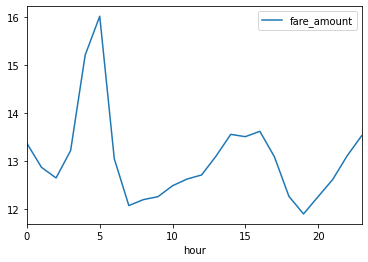

In [18]:
%matplotlib inline
taxi_df.groupby('hour').fare_amount.mean().to_pandas().sort_index().plot(legend=True)

2) Look at trips per day

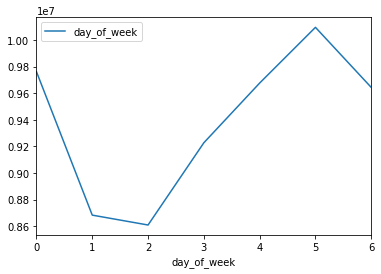

In [19]:
%matplotlib inline
taxi_df.groupby('day_of_week').day_of_week.count().to_pandas().sort_index().plot(legend=True)

3) Tips

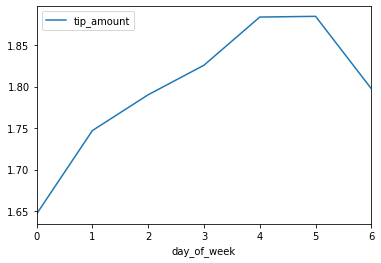

In [20]:
%matplotlib inline
taxi_df.groupby('day_of_week').tip_amount.mean().to_pandas().sort_index().plot(legend=True)

---

### Let's train a model to predict fare amounts

In [21]:
import xgboost as xgb

In [22]:
X_train = taxi_df.query('day < 25')

# create a Y_train ddf with just the target variable
Y_train = X_train[['fare_amount']]

# drop the target variable from the training ddf
X_train = X_train[X_train.columns.difference(['fare_amount'])]

# Create a DMatrix
dtrain = xgb.DMatrix(X_train, Y_train)

In [23]:
# Train XGBoost
params = {
    'learning_rate'  : 0.3,
    'max_depth'      : 8,
    'objective'      : 'reg:squarederror',
    'subsample'      : 0.6,
    'gamma'          : 1,
    'silent'         : True,
    'verbose_eval'   : True,
    'tree_method'    :'gpu_hist'
}

In [24]:
%%time
trained_model = xgb.train(params, dtrain)

[10:05:32] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 8.67 s, sys: 4.5 s, total: 13.2 s
Wall time: 13.2 s


In [25]:
X_test = taxi_df.query('day >= 25')

# Create Y_test with just the fare amount
Y_test = X_test[['fare_amount']]

# Drop the fare amount from X_test
X_test = X_test[X_test.columns.difference(['fare_amount'])]

dtest = xgb.DMatrix(X_test, Y_test)

In [26]:
%%time

# generate predictions on the test set
Y_test['prediction'] = trained_model.predict(dtest)



CPU times: user 59.2 ms, sys: 71.8 ms, total: 131 ms
Wall time: 129 ms


In [27]:
Y_test['squared_error'] = (Y_test['prediction'] - Y_test['fare_amount'])**2

# inspect the results to make sure our calculation looks right
Y_test.head()

,fare_amount,prediction,squared_error
177,9.0,8.610953,0.151357
178,41.0,38.185226,7.922950
179,9.0,8.782563,0.047279
180,4.5,4.284573,0.046409
181,9.0,9.022697,0.000515


In [28]:
# compute the actual RMSE over the full test set
RMSE = Y_test.squared_error.mean()
math.sqrt(RMSE)

1.1009639427034694

In [29]:
# cleanup
del trained_model
del X_test
del X_train
del Y_test
del Y_train
gc.collect()

4354

---
# Graph 
We need vertex IDs to be integer values but what we have are lat-long pairs (float64).  There are two way that we can address the issue. The hard way and an easy way

### Create vertices and edges the hard way

In [30]:
# create node ID from lat-long combinatiuons
nodes = [
      taxi_df[['pickup_longitude', 'pickup_latitude']].drop_duplicates().rename({'pickup_longitude': 'long', 'pickup_latitude': 'lat'})
    , taxi_df[['dropoff_longitude', 'dropoff_latitude']].drop_duplicates().rename({'dropoff_longitude': 'long', 'dropoff_latitude': 'lat'})
]

nodes = cudf.concat(nodes).drop_duplicates().reset_index(drop=True).reset_index().rename({'index': 'id'})
nodes.head(5)

,id,long,lat
0,0,-74.997330,41.879631
1,1,-74.988434,40.049549
2,2,-74.979439,41.489216
3,3,-74.977318,40.319294
4,4,-74.973709,40.591049


In [31]:
print('Total number of geo points in the dataset: {0:,}'.format(len(nodes)))

Total number of geo points in the dataset: 49,805,004


In [32]:
edges = (
    taxi_df[['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'trip_distance']]
    .drop_duplicates()
    .rename({'pickup_longitude': 'long', 'pickup_latitude': 'lat'})
    .merge(nodes, on=['lat', 'long'])
    .rename({'long': 'pickup_longitude', 'lat': 'pickup_latitude', 'id': 'pickup_id', 'dropoff_longitude': 'long', 'dropoff_latitude': 'lat'})
    .merge(nodes, on=['lat', 'long'])
    .rename({'long': 'dropoff_longitude', 'lat': 'dropoff_latitude', 'id': 'dropoff_id'})
)[['pickup_id', 'dropoff_id', 'trip_distance']]

edges.head(5)

,pickup_id,dropoff_id,trip_distance
0,92395,92039,0
1,92400,155735,0
2,92402,92233,0
3,92403,92524,0
4,92422,92418,0


In [33]:
#sources      = edges['pickup_id'].astype('int32')
#destinations = edges['dropoff_id'].astype('int32')
#distances    = edges['trip_distance'].astype('int32')

g = cugraph.Graph()
g.from_cudf_edgelist(edges, source='pickup_id', destination='dropoff_id')

## Graph distribution of degrees

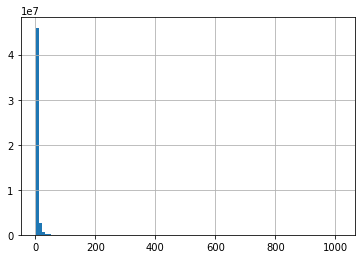

In [34]:
%matplotlib inline
g.degree().to_pandas()['degree'].hist(bins=100)

## Pagerank

In [35]:
page = cugraph.pagerank(g, alpha=.85, max_iter=1000, tol=1.0e-05)

In [36]:
page.sort_values(by='pagerank', ascending=False).head(5).to_pandas()

,vertex,pagerank
583597,48343377,0.000003
991186,49670386,0.000003
46290585,48342703,0.000003
1051996,49670396,0.000003
46254105,48342697,0.000003


## Now the easy way

In [37]:
# clean up the hard way structures
del g
del edges
del nodes
gc.collect()

75

In [38]:
# Get a subset of the data
taxi_df2 = taxi_df[['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']]
taxi_df2['count'] = 1

In [39]:
# remove duplicate edges (we currently do not support MultiGraphs - but it is on the roadmap)
# use a groupby so that we get a count of the number of similar trips
aggs = OrderedDict()
aggs['count'] = 'count'

grouped_df = taxi_df2.groupby(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'], as_index=False).agg(aggs) 

__Homework__
 * how many duplicates did we remove?
 * what if the lat/long information is rounded up (distance resolution decreased)?

In [40]:
g2 = cugraph.Graph()
g2.from_cudf_edgelist(grouped_df, 
                      source=['pickup_longitude', 'pickup_latitude'], 
                      destination=['dropoff_longitude', 'dropoff_latitude'], 
                      edge_attr='count',
                      renumber=True)

In [41]:
page = cugraph.pagerank(g2, alpha=.85, max_iter=1000, tol=1.0e-05)
page.sort_values(by='pagerank', ascending=False).head(5).to_pandas()

,0,1,pagerank
48343729,-73.870872,40.773739,0.000003
49684434,-73.776703,40.645370,0.000003
48339215,-73.870888,40.773762,0.000003
49684444,-73.776703,40.645409,0.000003
48339209,-73.870888,40.773739,0.000003


In [42]:
jdf = cugraph.jaccard(g2)
jdf.sort_values(by='jaccard_coeff', ascending=False).head()

,0_x,1_x,0_y,1_y,jaccard_coeff
3577,-74.246834,40.780643,-74.246826,40.780636,0.333333
3579,-74.246826,40.780636,-74.246834,40.780643,0.333333
120792963,-73.945610,40.751610,-73.945587,40.751625,0.333333
120814034,-73.945587,40.751625,-73.945610,40.751610,0.333333
3574,-74.246841,40.780655,-74.246834,40.780643,0.250000


In [43]:
# Are there travel clusters?  
clusters, mod = cugraph.louvain(g2)

In [50]:
print(f"the graph contains {len(clusters):,} clusters with a modularity score of {mod:2f}")

the graph contains 49,805,004 clusters with a modularity score of 0.703463
